In [5]:
!pip install git+https://github.com/google-research/zapbench.git#egg=zapbench

  Cloning https://github.com/google-research/zapbench.git to /tmp/pip-install-3_fmq7ds/zapbench_799749c52884490c810d4361f4bf7b9e
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/zapbench.git /tmp/pip-install-3_fmq7ds/zapbench_799749c52884490c810d4361f4bf7b9e
  Resolved https://github.com/google-research/zapbench.git to commit c76cf007a0b544dc340c5e42b83b372b97114bc0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached clu-0.0.12-py3-none-any.whl.metadata (1.9 kB)
  Using cached connectomics-0.0.3-py3-none-any.whl.metadata (2.1 kB)
  Using cached distrax-0.1.5-py3-none-any.whl.metadata (13 kB)
  Using cached dm_pix-0.4.4-py3-none-any.whl.metadata (7.1 kB)
  Using cached grain_nightly-0.0.10-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
  Using cached ml_collections-1.1.0-py3-none-any.whl.metadata (22 kB)
  Using cached ja

In [4]:
!python --version

Python 3.11.11


In [6]:
from zapbench import constants
from zapbench import data_utils
from zapbench.ts_forecasting import data_source


In [6]:
constants.CONDITION_NAMES

('gain',
 'dots',
 'flash',
 'taxis',
 'turning',
 'position',
 'open loop',
 'rotation',
 'dark')

In [7]:
constants.SPECS

{'240930_traces': {'kvstore': 'gs://zapbench-release/volumes/20240930/traces/',
  'driver': 'zarr3',
  'transform': {'input_exclusive_max': [[7879], 71721],
   'input_inclusive_min': [0, 0],
   'input_labels': ['t', 'f']}}}

In [10]:
from enum import Enum

class ContextType(Enum):
    SHORT = 4
    LONG = 256

class Split(Enum):
    train = "train"
    val = "val"
    test = "test"
    test_holdout = "test_holdout"
    train_val = "train_val"
    none: "None"



In [11]:
config = data_source.TensorStoreTimeSeriesConfig(
    input_spec = data_utils.adjust_spec_for_condition_and_split(
        condition = constants.CONDITION_NAMES.index("turning"),
        split = Split.train.value,
        spec = data_utils.get_spec('240930_traces'),
        num_timesteps_context = ContextType.SHORT.value
    ),
    timesteps_input = ContextType.SHORT.value,
    timesteps_output = constants.PREDICTION_WINDOW_LENGTH
)

source = data_source.TensorStoreTimeSeries(config)

print(f'{len(source)=}') #this is the number of sliding windows within the set, 


E0506 02:02:04.222092     171 google_auth_provider.cc:188] Could not find the credentials file in the standard gcloud location [/content/.config/application_default_credentials.json]. You may specify a credentials file using $GOOGLE_APPLICATION_CREDENTIALS, or to use Google application default credentials, run: gcloud auth application-default login


len(source)=882


In [10]:
type(source)

zapbench.ts_forecasting.data_source.TensorStoreTimeSeries

In [11]:
source.item_shape

{'timestep': (), 'series_input': (4, 71721), 'series_output': (32, 71721)}

ok tldr

source is timestep, series_input of (C, num neurons), series output of (H, num neurons)

theres 917 timesteps
grabbing one timestep, you can get the activiation of all neurons at that first timestep 
since its a 2-d array with shape 4, 71k, the 4 is the 4 timesteps for context, column is the data for each neuron 

In [12]:
source # scalar timestep, series_input of (C, num neurons), series output of (H, num neurons)

TensorStoreTimeSeries(config=TensorStoreTimeSeriesConfig(input_spec=Spec({
  'driver': 'zarr3',
  'kvstore': {
    'bucket': 'zapbench-release',
    'driver': 'gcs',
    'path': 'volumes/20240930/traces/',
  },
  'transform': {
    'input_exclusive_max': [917, 71721],
    'input_inclusive_min': [0, 0],
    'input_labels': ['t', 'f'],
    'output': [{'input_dimension': 0, 'offset': 3736}, {'input_dimension': 1}],
  },
}), timesteps_input=4, timesteps_output=32), prefetch=False, transforms=()), sequential=True

In [13]:
one_timestep = source[0] # series_input of (C, num neurons), series output of (H, num neurons)

In [14]:
series_input = one_timestep["series_input"] #just the series input array, which contains C rows, num neurons cols, 

In [15]:
series_input[0] #actiivations of all neurons at first timestep

array([0.03483408, 0.04651919, 0.04242025, ..., 0.09138791, 0.07891488,
       0.05562454], dtype=float32)

In [16]:
series_input[0][0] #the activity value of neuron #0 at the first context timestep

0.034834083

In [17]:
one_timestep["series_input"][:, 0] #“For every of the 4 rows (timesteps), pick column 0 (neuron 0).”

array([0.03483408, 0.03263443, 0.03508279, 0.02838318], dtype=float32)

In [18]:
one_timestep["series_input"][0, :]   #“For every of the 71k columns, pick row 0 (timestep 0).”

array([0.03483408, 0.04651919, 0.04242025, ..., 0.09138791, 0.07891488,
       0.05562454], dtype=float32)

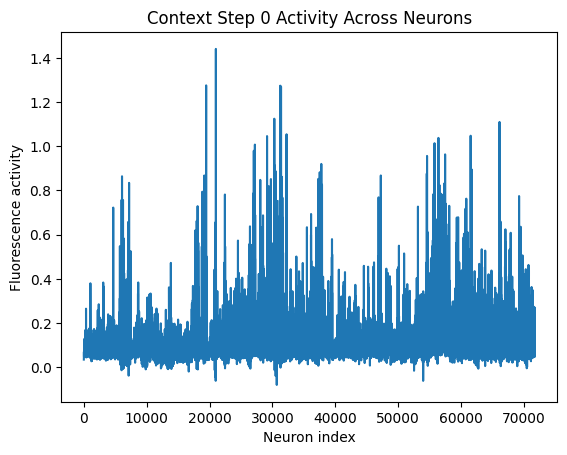

In [19]:

import matplotlib.pyplot as plt

plt.figure()
plt.plot(one_timestep["series_input"][0,:])
plt.xlabel("Neuron index")
plt.ylabel("Fluorescence activity")
plt.title("Context Step 0 Activity Across Neurons")
plt.show()


In [14]:
source = data_source.TensorStoreTimeSeries(config, prefetch=True)

at this point, you can repeat the config step over all ids in constants.CONDITIONS_TRAIN to get all sources
sources = []

# Iterate over all training conditions (excludes 'taxis'), and create
# data sources.
for condition_id in constants.CONDITIONS_TRAIN:
  config = data_source.TensorStoreTimeSeriesConfig(
      input_spec=data_utils.adjust_spec_for_condition_and_split(
          condition=condition_id,
          split='train',
          spec=data_utils.get_spec('240930_traces'),
          num_timesteps_context=num_timesteps_context),
      timesteps_input=num_timesteps_context,
      timesteps_output=constants.PREDICTION_WINDOW_LENGTH,
  )
  sources.append(data_source.TensorStoreTimeSeries(config, prefetch=True))

# Concatenate into a single source.
source = data_source.ConcatenatedTensorStoreTimeSeries(*sources)

f'{len(source)=}'

In [23]:
def mean(array):
    return array.mean(axis = 0).reshape((1, -1)).repeat(32, axis = 0)

In [25]:
from collections import defaultdict

from connectomics.jax import metrics


infer_source = data_source.TensorStoreTimeSeries(
    data_source.TensorStoreTimeSeriesConfig(
        input_spec=data_utils.get_spec('240930_traces'),
        timesteps_input=ContextType.SHORT.value,
        timesteps_output=constants.PREDICTION_WINDOW_LENGTH,
    ),
    prefetch=True
)

In [41]:
from tqdm import tqdm
import numpy as np 
# Placeholder for results
MAEs = defaultdict(list)

# Iterate over all conditions, and make predictions for all contiguous snippets
# of length 32 in the respective test set.
for condition_id, condition_name in tqdm(enumerate(constants.CONDITION_NAMES)):
  split = ('test' if condition_id not in constants.CONDITIONS_HOLDOUT
           else 'test_holdout')
  test_min, test_max = data_utils.adjust_condition_bounds_for_split(
      split,
      *data_utils.get_condition_bounds(condition_id),
      num_timesteps_context=ContextType.SHORT.value)
  print(f'{condition_name} test min is {test_min}')
  for window in range(
      data_utils.get_num_windows(test_min, test_max, ContextType.SHORT.value)):
    element = infer_source[test_min + window]

    predictions = mean(element['series_input'])
    mae = metrics.mae(predictions=predictions, targets=element['series_output'])

    MAEs[condition_name].append(np.array(mae))

0it [00:00, ?it/s]

gain test min is 515


1it [00:00,  1.76it/s]

dots test min is 2063


2it [00:02,  1.15s/it]

flash test min is 2943


3it [00:02,  1.17it/s]

taxis test min is 3331


4it [00:04,  1.26s/it]

turning test min is 4780


5it [00:05,  1.24s/it]

position test min is 5516


6it [00:06,  1.02it/s]

open loop test min is 6422


7it [00:07,  1.07it/s]

rotation test min is 7144


8it [00:07,  1.25it/s]

dark test min is 7755


9it [00:07,  1.13it/s]


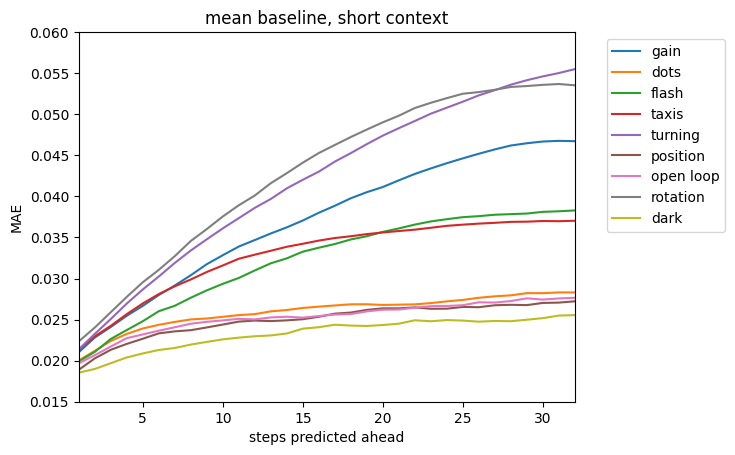

In [42]:
import matplotlib.pyplot as plt


steps_ahead = np.arange(32) + 1

for condition_name in constants.CONDITION_NAMES:
  mae = np.stack(MAEs[condition_name]).mean(axis=0)  # Average over windows
  plt.plot(steps_ahead, mae, label=condition_name)

plt.title('mean baseline, short context')
plt.xlabel('steps predicted ahead')
plt.ylabel('MAE')
plt.ylim((0.015, 0.06))
plt.xlim(1, 32)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [37]:
from connectomics.common import ts_utils
import pandas as pd


# Load dataframe with results reported in the manuscript.
df = pd.DataFrame(
    ts_utils.load_json(f'gs://zapbench-release/dataframes/20250131/combined.json'))
df.head()

,method,context,condition,steps_ahead,xid,MAE,MSE
0,mean,4,gain,1,146317468/3,0.021029,0.001155
1,mean,4,gain,10,146317468/3,0.032838,0.003546
2,mean,4,gain,11,146317468/3,0.033893,0.003813
3,mean,4,gain,12,146317468/3,0.034685,0.004049
4,mean,4,gain,13,146317468/3,0.035484,0.004284


In [38]:
for condition_name in constants.CONDITION_NAMES:
  mae = np.stack(MAEs[condition_name]).mean(axis=0)
  mae_df = df.query(
      f'method == "mean" and context == 4 and condition == "{condition_name}"'
  ).sort_values('steps_ahead')['MAE'].to_numpy()
  
  
print("lol ",   np.testing.assert_array_almost_equal(mae, mae_df, decimal=8))

lol  None
